In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.signal import periodogram
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.signal import find_peaks
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.dates as mdates
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
import subprocess
import sys

## Obteniendo los datos

Para obtener los datos puedes correr el script download_data.py. Este script descargará los datos de precios del oro desde Kaggle y los guardará en la carpeta `data`. Necesitarás tu nombre de usuario y token de Kaggle para autenticarte.

```bash
python download_data.py
```
Para descargar los datos manualmente, puedes visitar el siguiente enlace: [Kaggle Gold Prices Dataset](https://www.kaggle.com/datasets/nisargchodavadiya/daily-gold-price-20152021-time-series).
Asegúrate de colocar el archivo `Gold Price.csv` en la carpeta `data` del proyecto.

In [2]:
gold_dataset_addr = "./data/Gold Price.csv"
gold_dataset = pd.read_csv(gold_dataset_addr)
gold_dataset.head(10)

,Date,Price,Open,High,Low,Volume,Chg%
0,2025-01-06,77149,77309,77542,76545,27160,0.44
1,2025-01-03,76813,77246,78600,76613,60,-0.05
2,2025-01-02,76849,76849,76849,76849,0,0.83
3,2025-01-01,76214,76232,76302,76053,60,-0.02
4,2024-12-31,76232,75680,76970,75572,1920,0.95
5,2024-12-30,75517,75443,76450,75336,10260,-0.35
6,2024-12-27,75783,76160,76445,75661,15260,-0.43
7,2024-12-26,76114,75868,76200,75760,9730,0.73
8,2024-12-24,75562,75625,75688,75424,10820,0.07
9,2024-12-23,75506,75680,75964,75352,14200,-0.37


In [3]:
gold_dataset.tail(3)

,Date,Price,Open,High,Low,Volume,Chg%
2845,2014-01-03,29727,30031,30125,29539,3050,-0.83
2846,2014-01-02,29975,29678,30050,29678,3140,1.47
2847,2014-01-01,29542,29435,29598,29340,2930,0.25


## Preprocesamiento y limpieza

```python

In [4]:
gold_dataset.info()
gold_dataset.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2848 entries, 0 to 2847
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2848 non-null   object 
 1   Price   2848 non-null   int64  
 2   Open    2848 non-null   int64  
 3   High    2848 non-null   int64  
 4   Low     2848 non-null   int64  
 5   Volume  2848 non-null   int64  
 6   Chg%    2848 non-null   float64
dtypes: float64(1), int64(5), object(1)
memory usage: 155.9+ KB


Index(['Date', 'Price', 'Open', 'High', 'Low', 'Volume', 'Chg%'], dtype='object')

### Pasos a seguir:

- Establecer 'Date' como índice
- Convertir índice 'Date' en datetime
- Ordenar el DataFrame por índice
- Cambiar la frecuencia del índice a días hábiles
- Verificar valores nulos
- De encontrar valores nulos, rellenar con el valor anterior
- Convertir 'Price' de rupias indias a dólares estadounidenses

In [5]:
gold_dataset.isnull().sum()

Date      0
Price     0
Open      0
High      0
Low       0
Volume    0
Chg%      0
dtype: int64

In [6]:
gold_dataset.set_index('Date', inplace=True)

In [7]:
gold_dataset.index = pd.to_datetime(gold_dataset.index)
gold_dataset = gold_dataset.sort_index()
gold_dataset = gold_dataset.asfreq('B')

In [8]:
gold_dataset['Price'].isna().sum()

np.int64(49)

In [9]:
gold_dataset['Price'] = gold_dataset['Price'].ffill()

In [10]:
gold_dataset['Price'].isna().sum()

np.int64(0)

Para la tasa de conversión, usaremos el valor de 85.96 INR por 1 USD, que es el tipo de cambio aproximado en julio de 2025.

In [11]:
conversion_rate = 85.96
price_columns = ['Price', 'Open', 'High', 'Low']

for col in price_columns:
    gold_dataset[col] =round(gold_dataset[col].astype(float) / conversion_rate, 2)


In [12]:
gold_dataset.dtypes

Price     float64
Open      float64
High      float64
Low       float64
Volume    float64
Chg%      float64
dtype: object

In [13]:
gold_dataset.head()

,Price,Open,High,Low,Volume,Chg%
Date,,,,,,
2014-01-01,343.67,342.43,344.32,341.32,2930.0,0.25
2014-01-02,348.71,345.25,349.58,345.25,3140.0,1.47
2014-01-03,345.82,349.36,350.45,343.64,3050.0,-0.83
2014-01-06,338.75,340.86,341.96,337.96,24380.0,-0.55
2014-01-07,336.89,338.88,339.63,336.34,18710.0,-0.55


### Análisis exploratorio de datos

In [14]:
fig = go.Figure()

# Add the gold price trace
fig.add_trace(go.Scatter(
    x=gold_dataset.index,
    y=gold_dataset['Price'],
    name='Gold Price',
    mode='lines'
))

# Update layout
fig.update_layout(
    title='Gold Price Over Time',
    xaxis_title='Date',
    yaxis_title='Price',
    showlegend=True,
    width=1000,
    height=500,
    margin=dict(l=20, r=20, t=60, b=20),
    plot_bgcolor='white',
    xaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGray'),
    yaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGray')
)

# Show the figure
fig.show()

De está gráfica podemos observar lo siguiente:
- La tendencia del precio es al alza.
- Se notan algunos periodos en los que el precio parece subir muy rápidamente, lo que indica que hay volatilidad.
- No parece haber patrones claros de estacionalidad.
- No parece haber cambios en generales en la tendencia.

In [15]:
gold_dataset['SMA_14'] = gold_dataset['Price'].rolling(window=14).mean()

# Create plot
fig = go.Figure()

# Plot original gold price
fig.add_trace(go.Scatter(
    x=gold_dataset.index,
    y=gold_dataset['Price'],
    name='Gold Price',
    mode='lines',
    line=dict(color='gold')
))

# Plot EMA
fig.add_trace(go.Scatter(
    x=gold_dataset.index,
    y=gold_dataset['SMA_14'],
    name='14-Day SMA',
    mode='lines',
    line=dict(color='darkgreen', width=2, dash='dot')
))

# Update layout
fig.update_layout(
    title='Gold Price with 14-Day Simple Moving Average',
    xaxis_title='Date',
    yaxis_title='Price',
    template='plotly_white',
    showlegend=True,
    width=1000,
    height=500,
    margin=dict(l=20, r=20, t=60, b=20),
    xaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGray'),
    yaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGray')
)

fig.show()

In [16]:
gold_dataset['EMA_14'] = gold_dataset['Price'].ewm(span=14, adjust=False).mean()

# Create plot
fig = go.Figure()

# Plot original gold price
fig.add_trace(go.Scatter(
    x=gold_dataset.index,
    y=gold_dataset['Price'],
    name='Gold Price',
    mode='lines',
    line=dict(color='gold')
))

# Plot EMA
fig.add_trace(go.Scatter(
    x=gold_dataset.index,
    y=gold_dataset['EMA_14'],
    name='14-Day EMA',
    mode='lines',
    line=dict(color='darkgreen', width=2, dash='dot')
))

# Update layout
fig.update_layout(
    title='Gold Price with 14-Day Exponential Moving Average',
    xaxis_title='Date',
    yaxis_title='Price',
    template='plotly_white',
    showlegend=True,
    width=1000,
    height=500,
    margin=dict(l=20, r=20, t=60, b=20),
    xaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGray'),
    yaxis=dict(showgrid=True, gridwidth=1, gridcolor='LightGray')
)

fig.show()


Tanto la media móvil simple (SMA) como la media móvil exponencial (EMA) nos permiten suavizar la serie de tiempo y observar mejor la tendencia del precio del oro. Cabe notar que la EMA da más peso a los precios recientes, lo que la hace más sensible a los cambios recientes en el precio.

Ahora analizaremos un poco más a fondo los mínimos locales en el precio. Para ello utilizamos la función `find_peaks` de `scipy.signal` para encontrar los mínimos locales. Luego verificamos si estos mínimos son "irreversibles", es decir, si todos los precios posteriores son mayores o iguales al mínimo encontrado.

In [17]:
# --- Prepare data --------------------
gold = gold_dataset.copy()
gold = gold.sort_index().dropna(subset=['Price'])
prices = gold['Price'].values

# --- Local minima --------------------------
minima_indices, props = find_peaks(-prices, prominence=10)

# --- Irreversible minima ---
running_future_min = np.minimum.accumulate(prices[::-1])[::-1]
irreversible_mask = (prices == running_future_min) & np.isin(np.arange(len(prices)), minima_indices)
irreversible_indices = np.where(irreversible_mask)[0]
irreversible_prices = gold.iloc[irreversible_indices]

print("Total local minima:", len(minima_indices))
print("Total irreversible minima:", len(irreversible_indices))

# --- Plot ------------------------------------
fig = go.Figure()
fig.add_trace(go.Scatter(x=gold.index, y=prices, mode='lines', name='Price'))

fig.add_trace(go.Scatter(
    x=irreversible_prices.index,
    y=irreversible_prices['Price'],
    mode='markers', name='Irreversible minima',
    marker=dict(color='red', size=7, symbol='x')
))
fig.update_layout(
    title='Gold Price and Irreversible Minima',
    xaxis_title='Date', yaxis_title='Price',
    template='plotly_white', height=600, width=1000
)
fig.show()


Total local minima: 83
Total irreversible minima: 30


In [18]:
# --- Calculate days between consecutive irreversible minima ---
time_gaps = (
    irreversible_prices.index.to_series().diff().dt.days.dropna()
)

irreversible_prices_df = pd.DataFrame({
    'Start': irreversible_prices.index[:-1],
    'End': irreversible_prices.index[1:],
    'Days Between': time_gaps.values,
    'Price': irreversible_prices['Price'].iloc[1:].values
})

irreversible_prices_df.to_csv('data/irreversible_minima.csv', index=False)

print("Time Gaps Between Irreversible Minima:")
print(irreversible_prices_df)

Time Gaps Between Irreversible Minima:
        Start        End  Days Between   Price
0  2015-08-05 2015-12-17         134.0  288.11
1  2015-12-17 2016-12-21         370.0  315.30
2  2016-12-21 2017-07-07         198.0  323.55
3  2017-07-07 2017-12-12         158.0  329.43
4  2017-12-12 2018-08-16         247.0  340.57
5  2018-08-16 2018-11-30         106.0  351.16
6  2018-11-30 2019-05-02         153.0  362.99
7  2019-05-02 2019-05-21          19.0  365.77
8  2019-05-21 2019-07-01          41.0  387.95
9  2019-07-01 2019-09-30          91.0  428.96
10 2019-09-30 2019-12-12          73.0  436.94
11 2019-12-12 2020-01-14          33.0  458.85
12 2020-01-14 2020-03-16          62.0  460.07
13 2020-03-16 2021-03-29         378.0  509.00
14 2021-03-29 2021-09-29         184.0  529.90
15 2021-09-29 2021-11-03          35.0  546.31
16 2021-11-03 2021-12-02          29.0  550.34
17 2021-12-02 2022-01-10          39.0  552.25
18 2022-01-10 2022-01-28          18.0  554.35
19 2022-01-28 2022-09

Analizaremos si es posible trazar una línea de regresión a través de estos mínimos irreversibles. 

In [19]:
# === Convert date to numeric ===
X = mdates.date2num(irreversible_prices_df['Start']).reshape(-1, 1)
y = irreversible_prices_df['Price'].values

# === Fit models ===
linear_model = LinearRegression().fit(X, y)
y_pred_linear = linear_model.predict(X)

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)
poly_model = LinearRegression().fit(X_poly, y)
y_pred_poly = poly_model.predict(X_poly)

# === Sort for plotting ===
sorted_idx = X[:, 0].argsort()
start_sorted = irreversible_prices_df['Start'].iloc[sorted_idx]
y_linear_sorted = y_pred_linear[sorted_idx]
y_poly_sorted = y_pred_poly[sorted_idx]

# === Plot with Plotly ===
fig = go.Figure()

# Actual data
fig.add_trace(go.Scatter(
    x=irreversible_prices_df['Start'], y=irreversible_prices_df['Price'],
    mode='markers',
    name='Irreversible Minimum Price',
    marker=dict(color='black')
))

# Linear regression line
fig.add_trace(go.Scatter(
    x=start_sorted, y=y_linear_sorted,
    mode='lines',
    name='Linear Regression',
    line=dict(color='blue')
))

# Polynomial regression line
fig.add_trace(go.Scatter(
    x=start_sorted, y=y_poly_sorted,
    mode='lines',
    name='Polynomial Regression (Degree 2)',
    line=dict(color='red', dash='dash')
))

# Update layout (adjust height and remove annotation)
fig.update_layout(
    title='Price vs Start Date with Linear and Polynomial Regression',
    xaxis_title='Start Date',
    yaxis_title='Price',
    template='plotly_white',
    height=700,  # Increased height
    legend=dict(x=0.01, y=0.99)
)

fig.show()


Ahora verificamos si hay alguna anomalía en el precio. Para hacerlo calculamos la media y la desviación estandard en 'Price'. Marcamos los puntos que están a más de tres desviaciones estándard de la media.

In [20]:
mean = gold_dataset['Price'].mean()
std = gold_dataset['Price'].std()

print(f"Mean: {mean}, Standard Deviation: {std}")

Mean: 480.4243910925539, Standard Deviation: 167.399434914847


In [21]:
anomalies = gold_dataset[(gold_dataset['Price'] > mean + 3*std) | (gold_dataset['Price'] < mean - 3*std)]

print(f"Number of anomalies in price detected: {len(anomalies)}")

Number of anomalies in price detected: 0


In [22]:
gold_dataset['Growth_Rate'] = gold_dataset['Price'].pct_change() * 100
gold_growth = gold_dataset.dropna(subset=['Growth_Rate'])

Comparación del modelo aditivo con el modelo multiplicativo:

In [23]:
series = gold_dataset['Price']

# Decomposition by additive and multiplicative models
decomp_add = seasonal_decompose(series, model='additive', period=24)
decomp_mul = seasonal_decompose(series, model='multiplicative', period=24)
decomp_stl = STL(series, period=24).fit()


In [24]:
height = 800
width = 1200

# ========= TREND ==========
fig_trend = make_subplots(
    rows=3, cols=1,
    shared_xaxes=True,
    subplot_titles=["Trend (Additive)", "Trend (Multiplicative)", "Trend (STL)"],
    vertical_spacing=0.05
)

fig_trend.add_trace(go.Scatter(x=decomp_add.trend.index, y=decomp_add.trend, mode='lines'), row=1, col=1)
fig_trend.add_trace(go.Scatter(x=decomp_mul.trend.index, y=decomp_mul.trend, mode='lines'), row=2, col=1)
fig_trend.add_trace(go.Scatter(x=decomp_stl.trend.index, y=decomp_stl.trend, mode='lines'), row=3, col=1)

fig_trend.update_layout(
    height=height,
    width=width,
    title_text='Trend Component Comparison',
    showlegend=False
)

# ========= SEASONALITY ==========
fig_season = make_subplots(
    rows=3, cols=1,
    shared_xaxes=True,
    subplot_titles=["Seasonality (Additive)", "Seasonality (Multiplicative)", "Seasonality (STL)"],
    vertical_spacing=0.05
)

fig_season.add_trace(go.Scatter(x=decomp_add.seasonal.index, y=decomp_add.seasonal, mode='lines'), row=1, col=1)
fig_season.add_trace(go.Scatter(x=decomp_mul.seasonal.index, y=decomp_mul.seasonal, mode='lines'), row=2, col=1)
fig_season.add_trace(go.Scatter(x=decomp_stl.seasonal.index, y=decomp_stl.seasonal, mode='lines'), row=3, col=1)

fig_season.update_layout(
    height=height,
    width=width,
    title_text='Seasonality Component Comparison',
    showlegend=False
)

# ========= RESIDUALS ==========
fig_resid = make_subplots(
    rows=3, cols=1,
    shared_xaxes=True,
    subplot_titles=["Residuals (Additive)", "Residuals (Multiplicative)", "Residuals (STL)"],
    vertical_spacing=0.05
)

fig_resid.add_trace(go.Scatter(x=decomp_add.resid.index, y=decomp_add.resid, mode='lines'), row=1, col=1)
fig_resid.add_trace(go.Scatter(x=decomp_mul.resid.index, y=decomp_mul.resid, mode='lines'), row=2, col=1)
fig_resid.add_trace(go.Scatter(x=decomp_stl.resid.index, y=decomp_stl.resid, mode='lines'), row=3, col=1)

fig_resid.update_layout(
    height=height,
    width=width,
    title_text='Residual Component Comparison',
    showlegend=False
)

# ========= SHOW FIGURES ==========
fig_trend.show()
fig_season.show()
fig_resid.show()


Usamos la prueba ADF (Augmented Dickey-Fuller) para verificar la estacionariedad

In [25]:
result = adfuller(gold_dataset['Price'].dropna())

In [26]:
print("Estadístico ADF:", result[0])
print("p-value:", result[1])
for key, value in result[4].items():
    print(f'Valor crítico {key}: {value:.4f}')

Estadístico ADF: 1.8238529967426709
p-value: 0.998395170704541
Valor crítico 1%: -3.4326
Valor crítico 5%: -2.8626
Valor crítico 10%: -2.5673


De acuerdo con la prueba ADF, el p-valor es mayor a 0.05, lo que indica que no podemos rechazar la hipótesis nula de que la serie es no estacionaria. También el estadístico ADF es mayor que los valores críticos en 1% y 5% lo que refuerza la conclusión de que la serie no presenta evidencia suficiente para ser considerada estacionaria.

Aplicaremos una diferenciación de primer orden para hacer la serie estacionaria. Esto implica restar el valor actual del valor anterior.

In [27]:
gold_dataset['Price_diff'] = gold_dataset['Price'].diff()
price_diff = gold_dataset['Price_diff'].dropna()
print(price_diff.head())

Date
2014-01-02    5.04
2014-01-03   -2.89
2014-01-06   -7.07
2014-01-07   -1.86
2014-01-08   -0.29
Freq: B, Name: Price_diff, dtype: float64


In [28]:
adf_result_diff = adfuller(price_diff)

print("ADF Statistic:", adf_result_diff[0])
print("p-value:", adf_result_diff[1])
for key, value in adf_result_diff[4].items():
    print(f'Critical Value ({key}): {value:.4f}')

ADF Statistic: -15.289419340511394
p-value: 4.464321193324246e-28
Critical Value (1%): -3.4326
Critical Value (5%): -2.8626
Critical Value (10%): -2.5673


Luego de aplicar la diferenciación de primer orden, verificamos nuevamente la estacionariedad con la prueba ADF. El p-valor es menor a 0.05, lo que indica que podemos rechazar la hipótesis nula de que la serie es no estacionaria. También los valores críticos en 1% y 5% son menores que el estadístico de prueba. Esto nos indica que la serie diferenciada es claramente estacionaria.

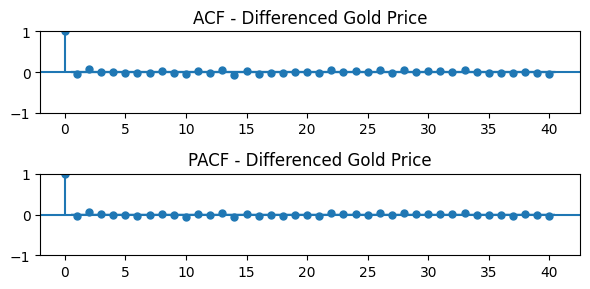

In [29]:
fig, axs = plt.subplots(2, 1, figsize=(6, 3))

# ACF plot (for MA terms)
plot_acf(price_diff, ax=axs[0], lags=40)
axs[0].set_title('ACF - Differenced Gold Price')

# PACF plot (for AR terms)
plot_pacf(price_diff, ax=axs[1], lags=40, method='ols')
axs[1].set_title('PACF - Differenced Gold Price')

plt.tight_layout()
plt.show()

Del gráfico de ACF y PACF podemos observar que luego del lag 0, los valores de ACF y PACF caen por debajo de 0.25, lo que sugiere que no hay correlación significativa en los lags posteriores. Esto quiere decir que en la serie solo tenemos ruido y no hay patrones significativos que podamos modelar de momento.
Intentaremos con la serie no diferenciada, ya que la serie diferenciada no tiene correlación significativa en los lags posteriores y la serie no diferenciada estaba dentro del intervalo de confianza del 90%.

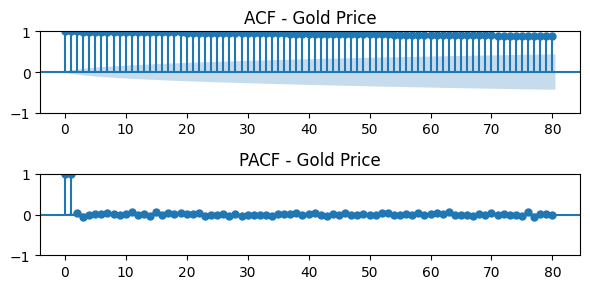

In [30]:
fig, axs = plt.subplots(2, 1, figsize=(6, 3))

# ACF plot (for MA terms)
plot_acf(gold_dataset['Price'], ax=axs[0], lags=80)
axs[0].set_title('ACF - Gold Price')

# PACF plot (for AR terms)
plot_pacf(gold_dataset['Price'], ax=axs[1], lags=80, method='ols')
axs[1].set_title('PACF - Gold Price')

plt.tight_layout()
plt.show()

La función de autocorrelación nos confirma que la serie es no estacionaria, pues la autocorrelación disminuye muy lentamente.

## MODELOS

In [31]:
def display_time_series_metrics_table(metrics_list):
    df = pd.DataFrame(metrics_list)
    df = df.set_index('Model')
    
    # Redondear métricas
    for col in df.columns:
        if df[col].dtype != 'O':
            df[col] = df[col].round(4)
    
    print("=" * 80)
    print("                      TIME SERIES MODELS COMPARISON")
    print("=" * 80)
    print(df.to_string())
    print("=" * 80)


Division de los datos en entrenamiento y test:

In [32]:
gold_dataset.index = pd.to_datetime(gold_dataset.index)
gold_dataset = gold_dataset.sort_index()
gold_dataset = gold_dataset.asfreq('B')

In [33]:
train = gold_dataset[:'2023-12-31']
test = gold_dataset['2024-01-01':]

### ARIMA

In [34]:
model = ARIMA(train['Price'], order=(0, 1, 0))
model_fit = model.fit()

In [35]:
n_steps = len(test)
arima_forecast = model_fit.forecast(steps=n_steps)

In [37]:
mae = mean_absolute_error(test['Price'], arima_forecast)
mse = mean_squared_error(test['Price'], arima_forecast)
rmse = np.sqrt(mse)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 95.03
RMSE: 108.59


In [38]:
# Función para calcular el MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [39]:
mse_arima = mean_squared_error(test['Price'], arima_forecast)
rmse_arima = np.sqrt(mse_arima)
mape_arima = mean_absolute_percentage_error(test['Price'], arima_forecast)
mae_arima = mean_absolute_error(test['Price'], arima_forecast)

In [40]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=train.index, y=train['Price'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=test.index, y=test['Price'], mode='lines', name='Test'))
fig.add_trace(go.Scatter(x=test.index, y=arima_forecast, mode='lines', name='Forecast'))

fig.update_layout(
    title="Gold Price Forecast: ARIMA(0,1,0)",
    xaxis_title="Date",
    yaxis_title="Price (INR)",
    template='plotly_white'
)

fig.show()

### Holt-Winters

In [41]:
hw_model = ExponentialSmoothing(
    train['Price'],
    trend='add',
    seasonal='add',
    seasonal_periods=24
).fit()

In [42]:
hw_forecast = hw_model.forecast(len(test))

# Evaluar desempeño
mae_hw = mean_absolute_error(test['Price'], hw_forecast)
rmse_hw = np.sqrt(mean_squared_error(test['Price'], hw_forecast))

print(f"Holt-Winters MAE: {mae_hw:.4f}")
print(f"Holt-Winters RMSE: {rmse_hw:.4f}")

Holt-Winters MAE: 76.4824
Holt-Winters RMSE: 86.8330


In [43]:
fig_hw = go.Figure()

fig_hw.add_trace(go.Scatter(x=train.index, y=train['Price'], mode='lines', name='Train'))
fig_hw.add_trace(go.Scatter(x=test.index, y=test['Price'], mode='lines', name='Test'))
fig_hw.add_trace(go.Scatter(x=test.index, y=hw_forecast, mode='lines', name='Forecast'))

fig_hw.update_layout(
    title="Gold Price Forecast: Holt-Winters",
    xaxis_title="Date",
    yaxis_title="Price (INR)",
    template='plotly_white'
)

fig_hw.show()

In [44]:
train_prophet = train.reset_index().rename(columns={'Date': 'ds', 'Price': 'y'})[['ds', 'y']]
test_prophet = test.reset_index().rename(columns={'Date': 'ds', 'Price': 'y'})[['ds', 'y']]

# Crear y entrenar modelo
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)
prophet_model.fit(train_prophet)

future = prophet_model.make_future_dataframe(periods=len(test), freq='D')
prophet_forecast = prophet_model.predict(future)

# Extraer solo las predicciones del periodo de prueba
forecast_filtered = prophet_forecast[['ds', 'yhat']].merge(test_prophet, on='ds', how='right')
prophet_forecast = forecast_filtered.set_index('ds')['yhat']

19:38:23 - cmdstanpy - INFO - Chain [1] start processing
19:38:24 - cmdstanpy - INFO - Chain [1] done processing


In [45]:
test_prophet['ds'] = pd.to_datetime(test_prophet['ds'])

actual = test_prophet.set_index('ds').reindex(prophet_forecast.index)['y']

df_eval = pd.DataFrame({
    'actual': actual,
    'forecast': prophet_forecast
}).dropna()

actual_clean = df_eval['actual']
forecast_clean = df_eval['forecast']

mae_prophet = mean_absolute_error(actual_clean, forecast_clean)
rmse_prophet = np.sqrt(mean_squared_error(actual_clean, forecast_clean))

print(f"Prophet MAE: {mae_prophet:.4f}")
print(f"Prophet RMSE: {rmse_prophet:.4f}")

Prophet MAE: 49.6508
Prophet RMSE: 58.2064


In [46]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=train_prophet['ds'],
    y=train_prophet['y'],
    mode='lines',
    name='Train'
))

fig.add_trace(go.Scatter(
    x=test_prophet['ds'],
    y=test_prophet['y'],
    mode='lines',
    name='Test'
))

fig.add_trace(go.Scatter(
    x=prophet_forecast.index,
    y=prophet_forecast.values,
    mode='lines',
    name='Forecast'
))

fig.update_layout(
    title="Gold Price Forecast: Prophet",
    xaxis_title="Date",
    yaxis_title="Price (INR)",
    template='plotly_white',
    height=500
)

fig.show()

In [47]:


# Holt-Winters
mae_hw = mean_absolute_error(test['Price'], hw_forecast)
rmse_hw = np.sqrt(mean_squared_error(test['Price'], hw_forecast))
mape_hw = mean_absolute_percentage_error(test['Price'], hw_forecast)

# Prophet
mae_prophet = mean_absolute_error(actual_clean, forecast_clean)
rmse_prophet = np.sqrt(mean_squared_error(actual_clean, forecast_clean))
mape_prophet = mean_absolute_percentage_error(actual_clean, forecast_clean)

# ARIMA
mse_arima = mean_squared_error(test['Price'], arima_forecast)
rmse_arima = np.sqrt(mse_arima)
mape_arima = mean_absolute_percentage_error(test['Price'], arima_forecast)

# Lista con todas las métricas
time_series_metrics_list = [
    {
        'Model': 'Holt-Winters',
        'MAE': mae_hw,
        'MSE': rmse_hw**2,
        'RMSE': rmse_hw,
        'MAPE': mape_hw
    },
    {
        'Model': 'Prophet',
        'MAE': mae_prophet,
        'MSE': rmse_prophet**2,
        'RMSE': rmse_prophet,
        'MAPE': mape_prophet
    },
    {
        'Model': 'ARIMA',
        'MAE': mae_arima,
        'MSE': mse_arima,
        'RMSE': rmse_arima,
        'MAPE': mape_arima
    }
]

In [48]:
def display_metrics_table(metrics_list):
    df = pd.DataFrame(metrics_list)
    df = df.set_index('Model')

    for col in ['R²', 'MAE', 'MSE', 'MAPE']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            df[col] = df[col].round(4 if col == 'R²' else 2)

    print("=" * 70)
    print("              MODELS COMPARISON")
    print("=" * 70)
    print(df.to_string())
    print("=" * 70)

# Mostrar tabla con todas las métricas
display_metrics_table(time_series_metrics_list)


              MODELS COMPARISON
                MAE       MSE        RMSE   MAPE
Model                                           
Holt-Winters  76.48   7539.97   86.832975   8.97
Prophet       49.65   3387.99   58.206400   6.02
ARIMA         95.03  11791.24  108.587488  11.12


#### Modelo de los mínimos irreversibles

In [49]:
def display_metrics_table(metrics_list):
    df = pd.DataFrame(metrics_list)
    df = df.set_index('Model')
    
    df['R²'] = df['R²'].round(4)
    df['MAE'] = df['MAE'].round(2)
    df['MSE'] = df['MSE'].round(2)
    df['MAPE'] = df['MAPE'].round(2)
    
    print("=" * 70)
    print("              MODELS COMPARISON")
    print("=" * 70)
    print(df.to_string())
    print("=" * 70)

In [50]:
# === Convert date to numeric ===
X = mdates.date2num(irreversible_prices_df['Start']).reshape(-1, 1)
y = irreversible_prices_df['Price'].values

# === Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# === Linear Regression ===
linear_model = LinearRegression().fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

# === Polynomial Regression (degree=2) ===
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

poly_model = LinearRegression().fit(X_train_poly, y_train)
y_pred_poly = poly_model.predict(X_test_poly)

# === Polynomial Ridge Regression ===
ridge_model = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree=2),
    Ridge(alpha=0.1, solver='auto'))

ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)

# === Custom MAPE function ===
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# === Evaluate models ===
def evaluate(name, y_true, y_pred):
    return {
        "Model": name,
        "R²": r2_score(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "MAPE": mean_absolute_percentage_error(y_true, y_pred)
    }

# === Evaluate ===
linear_metrics = evaluate("Linear Regression", y_test, y_pred_linear)
poly_metrics = evaluate("Polynomial Regression (deg=2)", y_test, y_pred_poly)
ridge_metrics = evaluate("Polynomial Ridge (deg=2)", y_test, y_pred_ridge)

metrics_list = [linear_metrics, poly_metrics, ridge_metrics]
display_metrics_table(metrics_list)


              MODELS COMPARISON
                                   R²     MAE       MSE   MAPE
Model                                                         
Linear Regression             -1.7017  107.36  14461.60  13.37
Polynomial Regression (deg=2)  0.4573   38.90   2905.08   4.64
Polynomial Ridge (deg=2)       0.4273   39.68   3065.36   4.73


In [51]:
linear_model_full = LinearRegression().fit(X, y)
y_pred_linear_full = linear_model_full.predict(X)

X_poly_full = poly.fit_transform(X)
poly_model_full = LinearRegression().fit(X_poly_full, y)
y_pred_poly_full = poly_model_full.predict(X_poly_full)

ridge_model_full = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree=2),
    Ridge(alpha=0.1, solver='auto')
)
ridge_model_full.fit(X, y)
y_pred_ridge_full = ridge_model_full.predict(X)

# Sort for plotting
sorted_idx = X[:, 0].argsort()
start_sorted = irreversible_prices_df['Start'].iloc[sorted_idx]
y_linear_sorted = y_pred_linear_full[sorted_idx]
y_poly_sorted = y_pred_poly_full[sorted_idx]

# === Plot with Plotly ===
fig = go.Figure()

# Actual data
fig.add_trace(go.Scatter(
    x=irreversible_prices_df['Start'], y=irreversible_prices_df['Price'],
    mode='markers', name='Irreversible Minimum Price',
    marker=dict(color='black')
))

# Linear Regression Line
fig.add_trace(go.Scatter(
    x=start_sorted, y=y_linear_sorted,
    mode='lines', name='Linear Regression',
    line=dict(color='blue')
))

# Polynomial Regression Line
fig.add_trace(go.Scatter(
    x=start_sorted, y=y_poly_sorted,
    mode='lines', name='Polynomial Regression (Degree 2)',
    line=dict(color='red', dash='dash')
))

# Polynomial Ridge Regression Line
X_sorted = X[sorted_idx] 
y_ridge_sorted = ridge_model_full.predict(X_sorted)

fig.add_trace(go.Scatter(
    x=start_sorted,
    y=y_ridge_sorted,
    mode='lines',
    name='Polynomial Ridge Regression (Degree 2)',
    line=dict(color='green', dash='dot')
))

fig.update_layout(
    title='Price vs Start Date with Linear and Polynomial Regression',
    xaxis_title='Start Date',
    yaxis_title='Price',
    template='plotly_white',
    height=700,
    legend=dict(x=0.01, y=0.99)
)

fig.show()